In [2]:
import requests
import json
import pandas as pd
import numpy as np

# Comment this out if you don't have dotenv installed and/or you'd rather just hardcode your api key. I put mine inside a .env - Ademide :)
import os
from dotenv import load_dotenv


### Part 1

### Part 2

**Obtaining data**

In [3]:
load_dotenv() # comment this out if you aren't putting the api key in a .env

# If you don't feel like installing dotenv just replace the api-key stuff with: api_key = "your_api_key_here"
api_key = os.getenv('TRANSITLAND_API_KEY')

base_url = "https://transit.land/api/v2/rest/routes"

In [4]:
# cities and coordinates
cities = [
    {"name": "Boston", "bbox": "-71.191155,42.227926,-70.986166,42.400819"},
    {"name": "New York", "bbox": "-74.259090,40.477399,-73.700272,40.917577"},
    {"name": "Chicago", "bbox": "-87.940101,41.643919,-87.523985,42.023131"},
    {"name": "San Francisco", "bbox": "-122.515,37.703,-122.357,37.812"}
]

# empty dict for the transit info
transit_dict = {
    'city': [],
    'route_name': [],
    'route_type': [],  # categorical route type
    'route_id_numeric': [],  # numeric value of the routeID
    'route_sort_order': [] # numeric value of route order
}


In [5]:
for city in cities:
    params = {
        "bbox": city['bbox'], 
        "limit": 50, # large enough number of routes
        "apikey": api_key
    }
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    # organize cols
    for route in data.get('routes', []):
        transit_dict['city'].append(city['name'])
        transit_dict['route_name'].append(route.get('route_long_name', route.get('route_short_name', 'Unknown')))
        
        # obtain categorical route type (0=tram, 1=subway, 2=rail, 3=bus, ...) to measure variability
        transit_dict['route_type'].append(route.get('route_type', 3))
        
        # obtain numeric value of the routeID
        route_id = route.get('id', 0)
        transit_dict['route_id_numeric'].append(route_id if isinstance(route_id, int) else hash(str(route_id)) % 10000)
        
        # obtain numeric value of route order, which notes priority of routes to measure efficiency
        transit_dict['route_sort_order'].append(route.get('route_sort_order', 999))

# convert to df
transit_df = pd.DataFrame(transit_dict)
display(transit_df.head(30))

,city,route_name,route_type,route_id_numeric,route_sort_order


**Cleaning data**

In [6]:
# lists unnamed routes as having an unknown name
transit_df['route_name'] = transit_df['route_name'].replace('', 'Unknown')
transit_df.loc[transit_df['route_name'].isna(), 'route_name'] = 'Unknown'\

# sets the route sor torder to a float and replaces any missing sort orders with 999
transit_df['route_sort_order'] = transit_df['route_sort_order'].fillna(999)
transit_df['route_sort_order'] = transit_df['route_sort_order'].astype(float)

# removes duplicate routes
transit_df = transit_df.drop_duplicates(subset=['city', 'route_id_numeric'], keep='first')

# makes all route types ints and replaces missing route types with 3
transit_df['route_type'] = transit_df['route_type'].fillna(3)
transit_df['route_type'] = transit_df['route_type'].astype(int)

display(transit_df.head(30))

,city,route_name,route_type,route_id_numeric,route_sort_order


**Merging Data**

In [7]:
# summarizes some the city statistics
city_summary = transit_df.groupby('city').agg({
    'route_id_numeric': 'count', # total number of routes in each city
    'route_type': 'nunique', # number of different types of transit
    'route_sort_order': 'mean' # average route priority, lower = more priority
}).reset_index()

# renames colums for the city summary
city_summary.columns = [
    'city',
    'total_routes',
    'route_type_diversity',
    'avg_route_priority'
]

# transit richness score
# 50% weight in number of cities
# 30% weight in the number of transit types
# 20% weight in the average priority
city_summary['transit_richness_score'] = (
    (city_summary['total_routes'] / city_summary['total_routes'].max() * 50) +
    (city_summary['route_type_diversity'] / city_summary['route_type_diversity'].max() * 30) +
    ((1 / (city_summary['avg_route_priority'] + 1)) / 
     (1 / (city_summary['avg_route_priority'] + 1)).max() * 20)
)

# classify cities by transit richness score
# above median = transit rich
# below median = transit limited
median_score = city_summary['transit_richness_score'].median()
city_summary['transit_category'] = city_summary['transit_richness_score'].apply(
    lambda x: 'Transit-Rich' if x >= median_score else 'Transit-Limited'
)

display(city_summary)

# merges the route data with the city summary
city_cols = ['city', 'total_routes', 'route_type_diversity', 'transit_richness_score', 'transit_category']
transit_df_merged = transit_df.merge(city_summary[city_cols], on='city', how='left')

display(transit_df_merged.head(30))

,city,total_routes,route_type_diversity,avg_route_priority,transit_richness_score,transit_category


,city,route_name,route_type,route_id_numeric,route_sort_order,total_routes,route_type_diversity,transit_richness_score,transit_category


### Part 3

The first implementation is a bar graph depicting the transit richness for each city.

C:\Users\Caleb\AppData\Local\Temp\ipykernel_18792\437101069.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Transit Category')


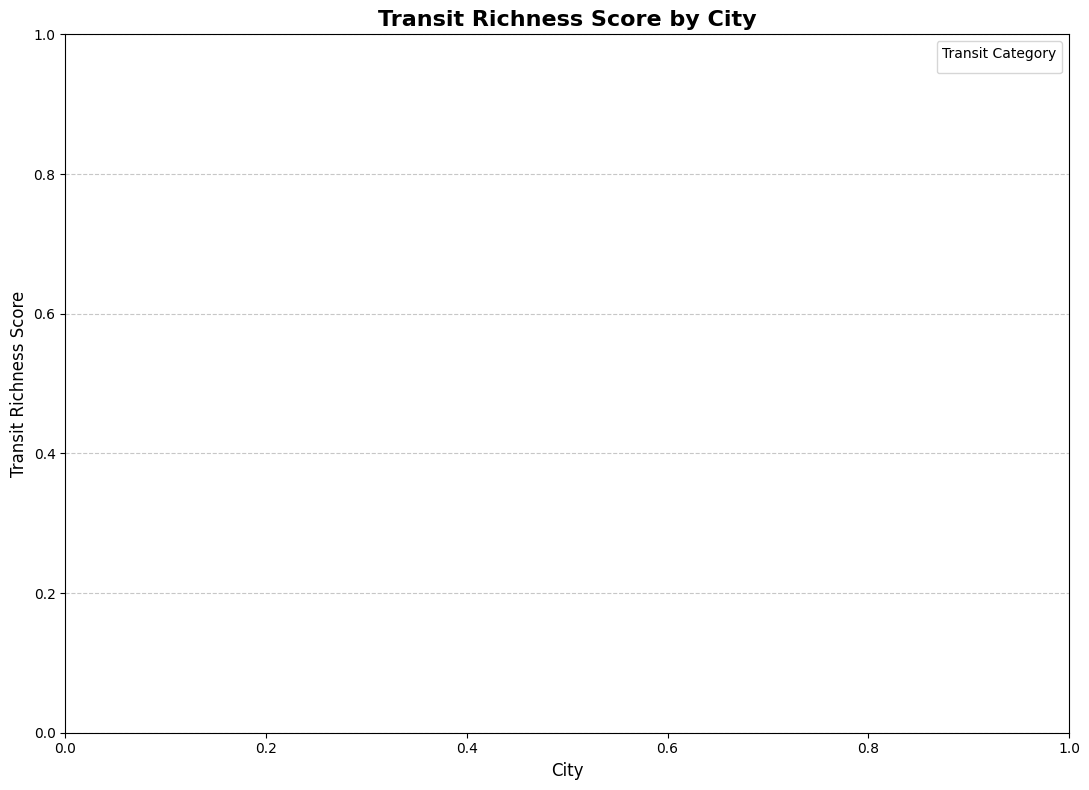

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_summary = city_summary.sort_values('transit_richness_score', ascending=False)

plt.figure(figsize=(11, 8))
sns.barplot(
    data=sorted_summary,
    x='city',
    y='transit_richness_score',
    hue='transit_category',
    dodge=False,
    palette={'Transit-Rich': 'mediumseagreen', 'Transit-Limited': 'salmon'}
)

plt.title('Transit Richness Score by City', fontsize=16, weight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Transit Richness Score', fontsize=12)
plt.legend(title='Transit Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The second implementation includes a scatterplot to show transit diversity versus the total number of routes.

C:\Users\Caleb\AppData\Local\Temp\ipykernel_18792\2503728528.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


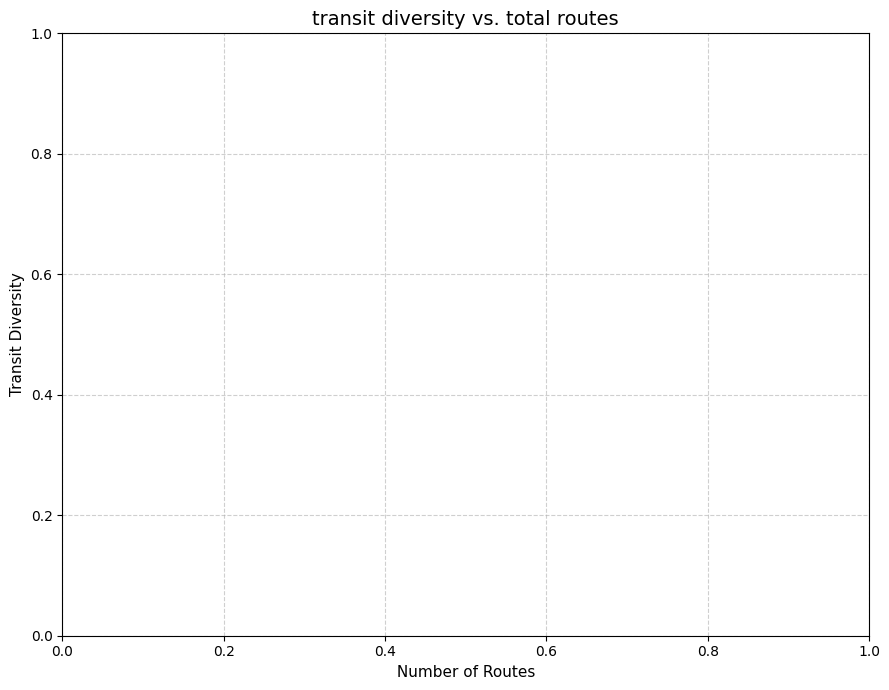

In [16]:
plt.figure(figsize=(9, 7))

sns.scatterplot(
    data=city_summary,
    x= 'total_routes',
    y ='route_type_diversity',
    size = 'transit_richness_score',
    hue= 'transit_richness_score',
    palette= 'viridis',
    sizes = (120, 620),
    legend = 'brief'
)

for i, row in city_summary.iterrows():
    plt.text(row['total_routes'] + 1, row['route_type_diversity'], row['city'], fontsize=9)

plt.title('transit diversity vs. total routes', fontsize=14)
plt.xlabel(' Number of Routes ', fontsize=11)
plt.ylabel('Transit Diversity', fontsize=11)
plt.grid( True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
